# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


## load data

In [ ]:
directory_data  = './drive/MyDrive/Machine_Learning/'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [ ]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## hyper-parameters

In [ ]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 200
size_minibatch  = 128
learning_rate   = 0.01
weight_decay    = 0.1

## custom data loader for the PyTorch framework

In [ ]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(np.long)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels
        

In [ ]:
#https://forensics.tistory.com/29
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience  = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

## construct datasets and dataloaders for training and testing

In [ ]:
dataset_train   = dataset(x_train, y_train)
dataset_test    = dataset(x_test, y_test)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_train.collate_fn)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True, collate_fn=dataset_test.collate_fn)

## shape of the data when using the data loader

In [ ]:
image, label    = next(iter(dataloader_train))
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([32, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([32])
************************************************************


## class for the neural network 

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.feature    = nn.Sequential(
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.BatchNorm2d(16),
            nn.ReLU(),

            # nn.Dropout(0.3),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.BatchNorm2d(32),
            nn.ReLU(),

            # nn.Dropout(0.3),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(4*4*256, 256, bias=True),
            # nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(256, 128, bias=True),
            nn.ReLU(),
            nn.Linear(128, 10, bias=True),
        )

        self.network    = nn.Sequential(
            self.feature,
            nn.Flatten(),
            self.classifier,
        )

        self.initialize()


    def initialize(self):

        for m in self.network.modules():

            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, input):

        output = self.network(input)

        return output

    

## build network

In [ ]:
classifier  = Classifier().to(device)
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

## print the defined neural network

In [ ]:
print(classifier)

Classifier(
  (feature): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (network): Sequential(
    (0): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 

## compute the prediction

In [ ]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [ ]:
def compute_loss(prediction, label):

    criterion   = nn.CrossEntropyLoss()
    loss        = criterion(prediction, label)
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [ ]:
def compute_accuracy(prediction, label):
    # ================================================================================ 
    # complete the function body
    b_Prediction = torch.argmax(prediction, 1)
    bCorrect = (b_Prediction == label)
    accuracy = bCorrect.float().mean()
    # ================================================================================ 

    return accuracy

## variables for the learning curve

In [ ]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train and test

In [ ]:
## For Debugging
classifier  = Classifier().to(device)
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)
early_stopping = EarlyStopping(patience=70, verbose=1)

# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):

        image_train = image_train.to(device)
        label_train = label_train.to(device)
        
        prediction_train                = compute_prediction(classifier, image_train)
        loss_train, loss_value_train    = compute_loss(prediction_train, label_train)
        accuracy_train                  = compute_accuracy(prediction_train, label_train).to("cpu")
        accuracy_train = accuracy_train.numpy()
        # loss_value_train = loss_value_train.to("cpu")

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    with torch.no_grad():
        classifier.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):

        image_test = image_test.to(device)
        label_test = label_test.to(device)
        
        prediction_test             = compute_prediction(classifier, image_test)
        loss_test, loss_value_test  = compute_loss(prediction_test, label_test)
        accuracy_test               = compute_accuracy(prediction_test, label_test).to("cpu")
        accuracy_test = accuracy_test.numpy()

        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test)
    accuracy_std_test[i]   = np.std(accuracy_test)

    if i % 10 == 0:
        print(f"epoch : {i}, train acc : {np.mean(accuracy_train_epoch)}, train loss : {np.mean(loss_train_epoch)}", end=' ')
        print(f"epoch : {i}, test acc : {np.mean(accuracy_test_epoch)}, test loss : {np.mean(loss_test_epoch)}")

    # if early_stopping.validate(np.mean(loss_test_epoch)):
    #     break



  0%|          | 1/200 [00:02<08:40,  2.61s/it]

epoch : 0, train acc : 0.4225499927997589, train loss : 1.9862911179542542 epoch : 0, test acc : 0.7105000019073486, test loss : 1.12560209107399


  6%|▌         | 11/200 [00:28<08:06,  2.58s/it]

epoch : 10, train acc : 0.8399999737739563, train loss : 0.5576951670408249 epoch : 10, test acc : 0.7879999876022339, test loss : 0.6559320489168167


 10%|█         | 21/200 [00:54<07:41,  2.58s/it]

epoch : 20, train acc : 0.8510000109672546, train loss : 0.5263680811405181 epoch : 20, test acc : 0.9077500104904175, test loss : 0.4872339969873428


 16%|█▌        | 31/200 [01:19<07:14,  2.57s/it]

epoch : 30, train acc : 0.8511000275611877, train loss : 0.520388075041771 epoch : 30, test acc : 0.9087499976158142, test loss : 0.4984893138408661


 20%|██        | 41/200 [01:45<06:49,  2.57s/it]

epoch : 40, train acc : 0.8568999767303467, train loss : 0.5141457511901856 epoch : 40, test acc : 0.9051250219345093, test loss : 0.4798963004350662


 22%|██▏       | 43/200 [01:51<06:46,  2.59s/it]


KeyboardInterrupt: ignored

## plot curve

In [ ]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [ ]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [ ]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [ ]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [ ]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [ ]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [ ]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [ ]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [ ]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [ ]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [ ]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

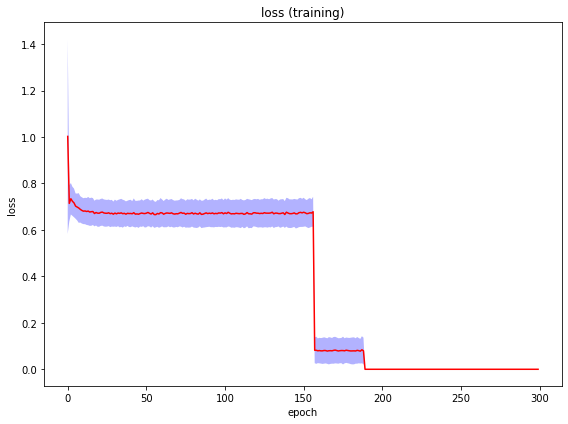

In [ ]:
function_result_01()

## # 02. plot the training accuracy curve (mean, std)

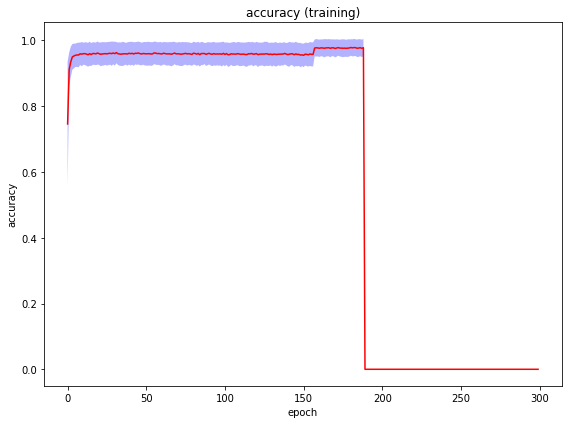

In [ ]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

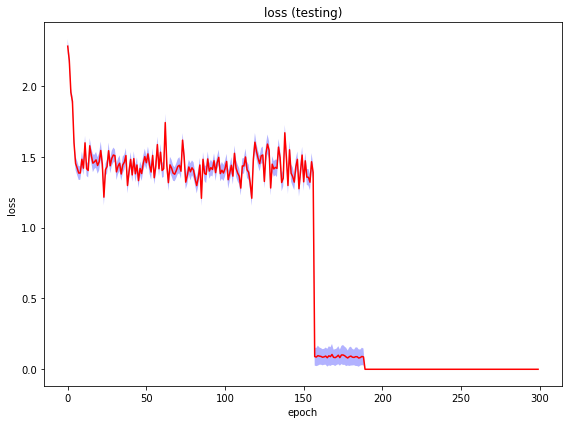

In [ ]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

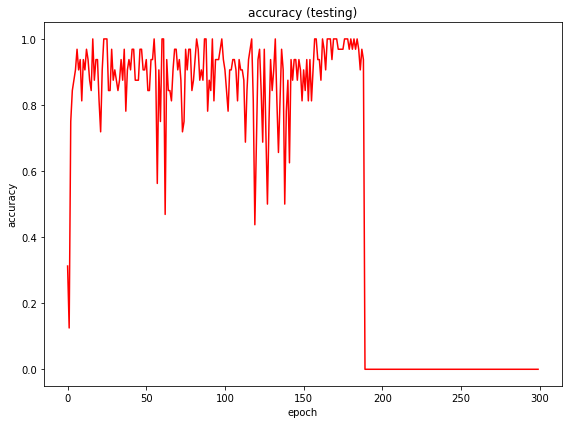

In [ ]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [ ]:
function_result_05()

index =  0, value = 0.0000000000
index =  1, value = 0.0000000000
index =  2, value = 0.0000000000
index =  3, value = 0.0000000000
index =  4, value = 0.0000000000
index =  5, value = 0.0000000000
index =  6, value = 0.0000000000
index =  7, value = 0.0000000000
index =  8, value = 0.0000000000
index =  9, value = 0.0000000000


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [ ]:
function_result_06()

index =  0, value = 0.0000000000
index =  1, value = 0.0000000000
index =  2, value = 0.0000000000
index =  3, value = 0.0000000000
index =  4, value = 0.0000000000
index =  5, value = 0.0000000000
index =  6, value = 0.0000000000
index =  7, value = 0.0000000000
index =  8, value = 0.0000000000
index =  9, value = 0.0000000000


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [ ]:
function_result_07()

index =  0, value = 0.0000000000
index =  1, value = 0.0000000000
index =  2, value = 0.0000000000
index =  3, value = 0.0000000000
index =  4, value = 0.0000000000
index =  5, value = 0.0000000000
index =  6, value = 0.0000000000
index =  7, value = 0.0000000000
index =  8, value = 0.0000000000
index =  9, value = 0.0000000000


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [ ]:
function_result_08()

index =  0, value = 0.0000000000
index =  1, value = 0.0000000000
index =  2, value = 0.0000000000
index =  3, value = 0.0000000000
index =  4, value = 0.0000000000
index =  5, value = 0.0000000000
index =  6, value = 0.0000000000
index =  7, value = 0.0000000000
index =  8, value = 0.0000000000
index =  9, value = 0.0000000000


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [ ]:
function_result_09()

best training accuracy = 0.0000000000


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [ ]:
function_result_10()

best testing accuracy = 0.0000000000
